# Link Prediction with Node2Vec

In [1]:
'''
source : http://education.abcom.com/link-prediction-using-node2vec/
'''

import random
from tqdm import tqdm
import networkx as nx
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# !wget https://github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/archive/master.zip -P "/content"
# ZipFile("/content/master.zip").extractall("/content/")
 
# graph
G = nx.read_gpickle('data/fb_repo/Graph.pickle')
# fb dataframe
fb = pd.read_csv('data/fb_repo/fb.csv', index_col=[0])

In [3]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1295
Number of edges: 18321
Average degree:  28.2950


In [4]:
fb.head()

,Node 1,Node 2
0,2,116
1,2,226
2,2,326
3,3,25
4,3,67


In [5]:
# create adj matrix
# get a list of nodes in our graph
l = list(G.nodes())
 
# create adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = l)
 
print(str(adj_G.shape)+'\n')
adj_G

(1295, 1295)



matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# find disconnected nodes
# get all node pairs which don't have an edge
non_existing_edges = []
 
# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if adj_G[i,j] == 0:
                non_existing_edges.extend([(l[i],l[j])])
 
    offset = offset + 1

100%|██████████| 1295/1295 [00:00<00:00, 1768.19it/s]


In [7]:
len(non_existing_edges)

819544

In [8]:
# get subset of isloated nodes 
nodes_4000 = sorted(random.sample(non_existing_edges, k=40000))

In [9]:
# Finding Connected Nodes
non_existing_edges = [(i[0],i[1]) for i in tqdm(nodes_4000) if nx.has_path(G, i[0], i[1])]

100%|██████████| 40000/40000 [00:18<00:00, 2191.46it/s]


In [10]:
non_existing_edges[:5]

[(2, 29), (2, 45), (2, 55), (2, 65), (2, 101)]

In [11]:
# create df of non existing edges
df1 = pd.DataFrame(data = non_existing_edges, columns =['Node 1', 'Node 2'])
 
# create a column 'Connection' with default 0 (no-connection)
df1['Connection'] = 0
 
df1.head()

,Node 1,Node 2,Connection
0,2,29,0
1,2,45,0
2,2,55,0
3,2,65,0
4,2,101,0


In [12]:
# get removable edges
# Create a list of all indices of the node pairs in the fb dataframe,
# which when removed won’t change the structure of our graph
 
# create a copy
fb_temp = fb.copy()
 
# for storing removable edges
removable_edges_indices = []
 
# number of connected components and nodes of G
ncc = nx.number_connected_components(G)
number_of_nodes = len(G.nodes)
 
# for each node pair we will be removing a node pair and creating a new graph,
# and check if the number of connected components and the number of nodes
# are the same as the original graph
for i in tqdm(fb.index.values):
  
    # remove a node pair and build a new graph
    G1 = nx.from_pandas_edgelist(
        fb_temp.drop(index= i), "Node 1", "Node 2", create_using=nx.Graph()
    )
  
    # If the number of connected components remain same as the original
    # graph we won't remove the edge
    if (nx.number_connected_components(G1) == ncc) and (len(G1.nodes) == number_of_nodes):
        removable_edges_indices.append(i)
 
    # drop the edge, so that for the next iteration the next G1
    # is created without this edge
    fb_temp = fb_temp.drop(index = i)

100%|██████████| 18321/18321 [03:53<00:00, 78.32it/s]  


In [13]:
removable_edges_indices[:5]

[0, 1]

In [14]:
# Creating Dataframe of Removable Edges
# get node pairs in fb dataframe with indices in removable_edges_indices
df2 = fb.loc[removable_edges_indices]
 
# create a column 'Connection' and assign default value of 1 (connected nodes)
df2['Connection'] = 1
 
df2.head()

,Node 1,Node 2,Connection
0,2,116,1
1,2,226,1


In [15]:
# Creating Subgraph
df1 = df1.append(df2[['Node 1', 'Node 2', 'Connection']], ignore_index=True)

In [16]:
df1.head()

,Node 1,Node 2,Connection
0,2,29,0
1,2,45,0
2,2,55,0
3,2,65,0
4,2,101,0


In [17]:
df3 = fb.drop(index=df2.index.values)


In [18]:
df3.head()


,Node 1,Node 2
2,2,326
3,3,25
4,3,67
5,3,142
6,3,170


In [19]:
G_new = nx.from_pandas_edgelist(df3, "Node 1", "Node 2", create_using=nx.Graph())

print(nx.info(G_new))

Name: 
Type: Graph
Number of nodes: 1295
Number of edges: 18319
Average degree:  28.2919


## Apply Node2Vec

In [20]:
from node2vec import Node2Vec
 
# Generating walks
node2vec = Node2Vec(G_new, dimensions=100, walk_length=16, num_walks=50)
 
# training the node2vec model
n2v_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/1295 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


In [21]:
edge_features = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df1['Node 1'], df1['Node 2'])]

## Modelling

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix


In [23]:
# creating dataset
X = np.array(edge_features)  
y = df1['Connection']

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## Grid Search CV

### Random Forest

In [25]:
#classifier
clf1 = RandomForestClassifier()
 
# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}
 
# model
grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)
 
# train the model
grid_clf_acc1.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc1 = GridSearchCV(clf1, param_grid = param, scoring = 'roc_auc')
grid_clf_auc1.fit(X_train, y_train)
predict_proba = grid_clf_auc1.predict_proba(X_test)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc1.best_params_)
print('Grid best score (AUC): ', grid_clf_auc1.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 5, 'n_estimators': 10}
Grid best score (accuracy):  0.9999601434834595
Test set AUC:  1.0
Grid best parameter (max. AUC):  {'max_depth': 5, 'n_estimators': 10}
Grid best score (AUC):  nan


### Gradient Boost

In [26]:
# classifier
clf2 = GradientBoostingClassifier()
 
# parameters
param = {'learning_rate' : [.05,.1]}
 
# model
grid_clf_acc2 = GridSearchCV(clf2, param_grid = param)
 
# train the model
grid_clf_acc2.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc2.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc2.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc2 = GridSearchCV(clf2, param_grid = param, scoring = 'roc_auc')
grid_clf_auc2.fit(X_train, y_train)
predict_proba = grid_clf_auc2.predict_proba(X_test)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc2.best_params_)
print('Grid best score (AUC): ', grid_clf_auc2.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.05}
Grid best score (accuracy):  nan
Test set AUC:  1.0
Grid best parameter (max. AUC):  {'learning_rate': 0.05}
Grid best score (AUC):  nan


### MLP Classifier (A Neural Network Classifier)

In [27]:
# classifier
clf3 = MLPClassifier(max_iter=1000)
 
# scaling training and test sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# parameters
param = {'hidden_layer_sizes' : [10,100,[10,10]], 'activation' : ['tanh','relu'], 'solver' : ['adam','lbfgs']}
 
# model
grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)
 
# train the model
grid_clf_acc3.fit(X_train_scaled, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc3 = GridSearchCV(clf3, param_grid = param, scoring = 'roc_auc')
grid_clf_auc3.fit(X_train_scaled, y_train)
predict_proba = grid_clf_auc3.predict_proba(X_test_scaled)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc3.best_params_)
print('Grid best score (AUC): ', grid_clf_auc3.best_score_)

Grid best parameter (max. accuracy):  {'activation': 'tanh', 'hidden_layer_sizes': 10, 'solver': 'adam'}
Grid best score (accuracy):  0.9999601434834595
Test set AUC:  0.014591556033967223
Grid best parameter (max. AUC):  {'activation': 'tanh', 'hidden_layer_sizes': 10, 'solver': 'adam'}
Grid best score (AUC):  nan


In [28]:
# Inference
pred = grid_clf_auc3.predict(X_test_scaled)
pred[:5]


array([0, 0, 0, 0, 0])

In [29]:
# Accuracy Score
accuracy_score(pred,y_test)

0.9998804113848362

In [30]:
# Confusion Matrix
confusion_matrix(pred,y_test)


array([[8361,    1],
       [   0,    0]])

In [31]:
# The ROC_AUC Score and ROC Curve
predict_proba = grid_clf_auc3.predict_proba(X_test_scaled)[:,1]
 
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

Text(0, 0.5, 'True Positive Rate')

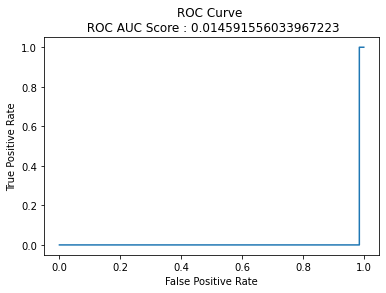

In [32]:
plt.plot(false_positive_rate,true_positive_rate)
plt.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Demonstration

In [33]:
df1.head()


,Node 1,Node 2,Connection
0,2,29,0
1,2,45,0
2,2,55,0
3,2,65,0
4,2,101,0


In [34]:
print(f' ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair features : {X[4]}')

# its position in X_train
print(f'Index of ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair in X_train : {np.where(X_train == X[4])[0][1]}')

 (2,101) node pair features : [-0.7674666   1.3457725   1.0491103   0.27405986 -0.29816723 -0.8041369
 -0.04937111  0.5476244   0.44762075  1.2813972   0.27891624 -1.0355995
  0.33194026  0.18202142 -0.46156418 -0.05700569  0.32990643 -1.1798482
 -0.476142    0.17035276  1.3334757   1.0028739   0.5485195   0.1650109
 -0.39757916  0.56784856 -1.6782901  -0.02200484 -0.52582633  0.02400509
  0.7076404  -0.22959585  0.03609795  1.2384543  -1.2464812   0.2521426
 -0.5306414  -0.5780925   1.0171802  -0.6116117  -0.10433644 -0.71655536
  0.05684356  0.15698346  0.4194678   0.25071633 -1.2348742   0.82659364
  0.42952633 -0.7425573   0.8238494  -0.74748814  0.1782543   0.3376378
 -0.251293   -0.316595    0.55764306  0.01676691  0.20783888 -0.3224166
 -0.22592616 -0.16078565 -0.02986461  0.15137595 -1.8215892  -0.3426879
  0.52364373  0.5141468  -0.43747967  0.4686327  -0.8638551  -0.69419456
  0.2541243  -0.0606684   0.20838937  0.6177887  -1.1000614   0.9122839
  0.0221095  -0.1008268  -1.03

IndexError: index 1 is out of bounds for axis 0 with size 0

In [35]:
predict_proba = grid_clf_auc3.predict_proba(X_train_scaled[np.where(X_train == X[4])[0][1]].reshape(1,-1))[:,1]
 
print(f'Probability of nodes {df1.iloc[4,0]} and {df1.iloc[4,1]} to form a link is : {float(predict_proba)*100 : .2f}%')

IndexError: index 1 is out of bounds for axis 0 with size 0